In [1]:
from scipy.io import netcdf
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import glob
import geopandas as gpd
from rasterstats import zonal_stats

## Elevation

In [2]:


zones = "/Users/shivyucel/Documents/projects/DPhil/Code_Data/data/adm0_shp/france/clean_shp_v2.shp"
values = "/Users/shivyucel/Documents/projects/DPhil/Code_Data/data/elevation/ELE.tif"

gdf = gpd.read_file(zones)
gdf.set_crs(epsg=4326, inplace=True)

stats = gpd.GeoDataFrame(zonal_stats(gdf, values, stats=["mean"]))
gdf = gdf.join(stats)


/Users/shivyucel/opt/anaconda3/envs/geo2/lib/python3.11/site-packages/rasterstats/io.py:335: NodataWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn(


In [3]:
gdf.rename(columns = {'mean':'mean_elev'}, inplace=True)

Text(0.5, 1.0, 'Average elevation (m.a.s.l.) in French districts')

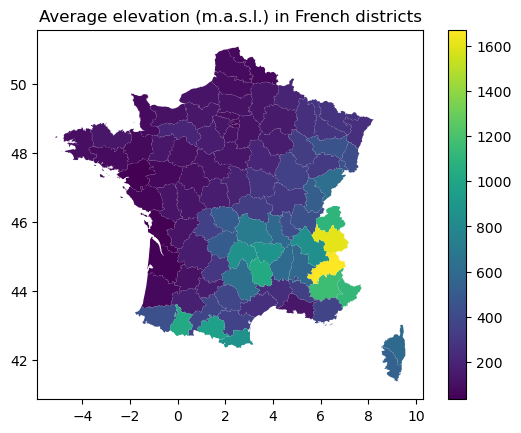

In [4]:
gdf.plot(column='mean_elev', legend=True )
plt.title("Average elevation (m.a.s.l.) in French districts")

In [5]:
gdf['location'] = gdf['adm2'] + ', ' + gdf['adm1']

## Coastal

In [6]:
coast = gpd.read_file('/Users/shivyucel/Documents/projects/DPhil/Code_Data/data/physical/france/coastline.shp')

In [7]:
coast['location'] = coast['adm2'] + ', ' + coast['adm1']

In [8]:
gdf['coast'] = [1 if x in coast['location'].unique() else 0 for x in gdf['location']]

<Axes: >

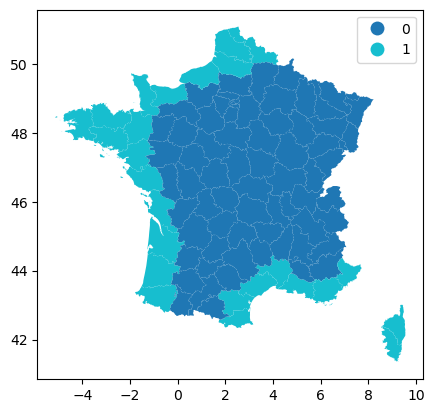

In [9]:
gdf.plot(column='coast', categorical= True, legend=True)

## Human Development Index

In [10]:
import pandas as pd

In [11]:
from unidecode import unidecode

gdf['no_accent'] = [unidecode(x) for x in gdf['adm1']]

In [12]:
hdi = pd.read_csv('/Users/shivyucel/Documents/projects/DPhil/Code_Data/data/demographic/france/GDL-Subnational-HDI-data.csv')

In [13]:
hdi.rename(columns={'2021':'HDI'}, inplace=True)

In [14]:
hdi.replace({'Ile de France': 'Ile-de-France'}, inplace=True)
hdi.replace({'Nord': 'Nord-Pas-de-Calais'}, inplace=True)
hdi.replace({'Provence-Alpes-Cote dAzur': "Provence-Alpes-Cote d'Azur"}, inplace=True)






In [15]:
gdf = gdf.merge(hdi[['Region', 'HDI']], left_on='no_accent', right_on='Region')

Text(0.5, 1.0, 'Provincial HDI France')

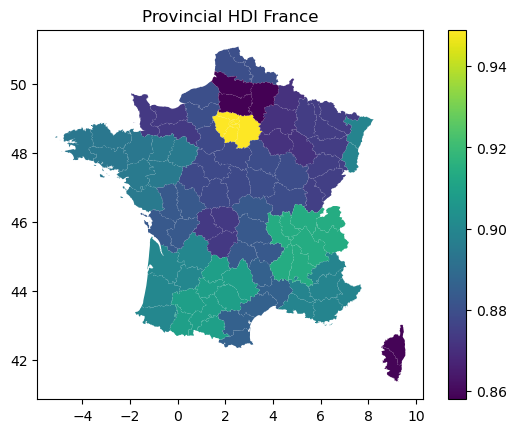

In [16]:
gdf.plot(column='HDI', legend=True)
plt.title('Provincial HDI France')

## Population density

In [17]:
#using WorldPop Global2 Populatoin Data Set
values = "/Users/shivyucel/Documents/projects/DPhil/Code_Data/paper2_repo/__clean/Global2/france/pop/fra_pop_2022_CN_1km_R2025A_UA_v1.tif"


stats = gpd.GeoDataFrame(zonal_stats(gdf, values, stats=["sum"]))
gdf = gdf.join(stats)


# choose correct projection for country
gdf = gdf.to_crs("EPSG:3035")

#Manually calculate area
gdf['area'] = gdf.geometry.area / 1e6

#manually calculate population density
gdf['popdens'] = gdf['sum'] / gdf['area']

gdf.rename(columns={'ADM0_EN':'adm0'}, inplace=True)


In [18]:
gdf.rename(columns={'mean':'popdens'}, inplace=True)

In [19]:
gdf = gdf[['adm0', 'adm1', 'adm2', 'geometry', 'mean_elev', 'location', 'coast', 'HDI', 'popdens']]

## Age

In [ ]:
gdf.to_crs(epsg=4326, inplace=True)

In [21]:
# use Global2 age data, summming over all total ages over 60 (deleting all other files in the folder)

gdf['over60_pop'] = 0
for file in glob.glob('/Users/shivyucel/Documents/projects/DPhil/Code_Data/paper2_repo/__clean/Global2/france/age/*'):
    
    values = file
    
    pop_total = gpd.GeoDataFrame(zonal_stats(gdf, values, stats=["sum"]))
    gdf['over60_pop'] += pop_total['sum']



#get total population in each adm2 region

for file in glob.glob('/Users/shivyucel/Documents/projects/DPhil/Code_Data/paper2_repo/__clean/Global2/france/pop/*'):
    
    values = file
    
    pop_sum = gpd.GeoDataFrame(zonal_stats(gdf, values, stats=["sum"]))
    gdf['pop_total'] = pop_sum['sum']


gdf['over60_propor'] = gdf['over60_pop'] / gdf['pop_total']

Text(0.5, 1.0, 'Age 60+ population proportion')

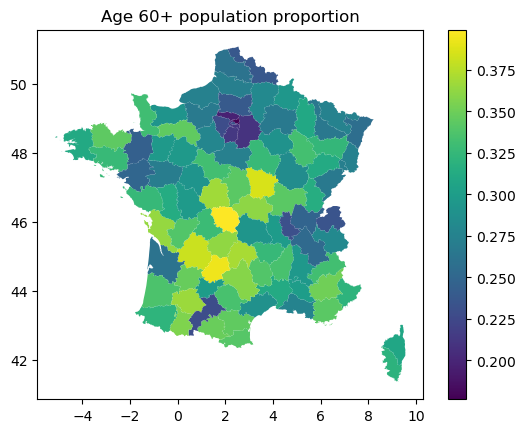

In [22]:
gdf.plot(column='over60_propor', legend=True)
plt.title("Age 60+ population proportion")

In [23]:
HDI_subset = gdf.drop_duplicates('HDI')

In [24]:
deciles = pd.qcut(HDI_subset['HDI'], 10, labels= range(1,11)).astype(int)
HDI_subset['HDI_dec'] = deciles
gdf = gdf.merge(HDI_subset[['HDI', 'HDI_dec']], on='HDI')

/Users/shivyucel/opt/anaconda3/envs/geo2/lib/python3.11/site-packages/geopandas/geodataframe.py:1968: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [25]:
gdf['popdens_dec'] = pd.qcut(gdf['popdens'], 10, labels= range(1,11)).astype(int)
gdf['over60_dec'] = pd.qcut(gdf['over60_propor'], 10, labels= range(1,11)).astype(int)

<Axes: >

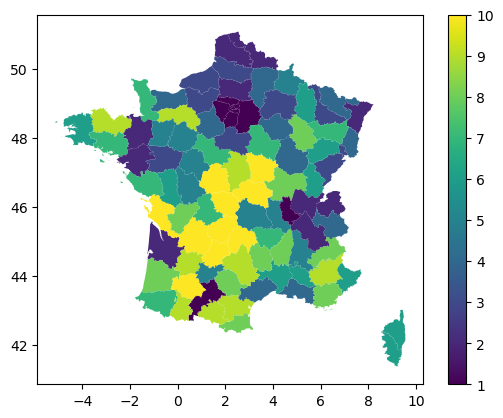

In [26]:
gdf.plot(column='over60_dec', legend=True)

In [72]:
gdf.to_file('/Users/shivyucel/Documents/projects/DPhil/Code_Data/data/physical/france/merged_Global2.shp')

/var/folders/8g/qp1k_1g91m5f2m9pypxwxdhh0000gn/T/ipykernel_67283/733850806.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf.to_file('/Users/shivyucel/Documents/projects/DPhil/Code_Data/data/physical/france/merged_Global2.shp')
/Users/shivyucel/opt/anaconda3/envs/geo2/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'over60_propor' to 'over60_pro'
  ogr_write(
/Users/shivyucel/opt/anaconda3/envs/geo2/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'popdens_dec' to 'popdens_de'
  ogr_write(
